In [1]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import fasttext
import fasttext.util

# Download NLTK resources (only needs to be done once)
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/i538819/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/i538819/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Load Data and Models

In [2]:
# Load CSV with all pairs
print("Loading CSV...")
df = pd.read_csv("data/full_dataset.csv")

# Paths to multilingual FastText aligned vectors (.vec files)
fasttext_model_paths = {
    'en': 'pretrained_models/fasttext/wiki.en.align.vec',
    'es': 'pretrained_models/fasttext/wiki.es.align.vec',
    'de': 'pretrained_models/fasttext/wiki.de.align.vec',
    'pl': 'pretrained_models/fasttext/wiki.pl.align.vec',
    'tr': 'pretrained_models/fasttext/wiki.tr.align.vec',
    'ar': 'pretrained_models/fasttext/wiki.ar.align.vec',
    'fr': 'pretrained_models/fasttext/wiki.fr.align.vec'
}

# Load and cache gensim models
fasttext_models = {}
for lang, path in fasttext_model_paths.items():
    print(f"Loading FastText model for {lang}...")
    fasttext_models[lang] = KeyedVectors.load_word2vec_format(path)

Loading CSV...
Loading FastText model for en...
Loading FastText model for es...
Loading FastText model for de...
Loading FastText model for pl...
Loading FastText model for tr...
Loading FastText model for ar...
Loading FastText model for fr...


## Preprocessing + Embeddings

In [3]:
def simple_preprocess(text):
    if not isinstance(text, str):
        text = ""
    return word_tokenize(text.lower())

In [4]:
def average_embedding(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

## Feature Extractors

In [5]:
def extract_features_lang_aware(feature_func):
    def wrapped(row):
        lang = row['lang1']
        model = fasttext_models.get(lang)
        if model is None:
            raise ValueError(f"No model found for language: {lang}")
        return feature_func(row, model)
    return wrapped

def extract_title_features(row, model_dict):
    tokens1 = simple_preprocess(row['title1'])
    tokens2 = simple_preprocess(row['title2'])

    vec1 = average_embedding(tokens1, model_dict)
    vec2 = average_embedding(tokens2, model_dict)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_text_features(row, model):
    tokens1 = simple_preprocess(row['text1'])
    tokens2 = simple_preprocess(row['text2'])

    vec1 = average_embedding(tokens1, model)
    vec2 = average_embedding(tokens2, model)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_combined_features(row, model):
    t1 = f"{row['title1']} {row['text1']}"
    t2 = f"{row['title2']} {row['text2']}"
    tokens1 = simple_preprocess(t1)
    tokens2 = simple_preprocess(t2)

    vec1 = average_embedding(tokens1, model)
    vec2 = average_embedding(tokens2, model)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_all_features(row, model):
    structured_cols = ['geography', 'entities', 'time', 'narrative', 'style', 'tone']
    # --- Title vector ---
    tokens_title1 = simple_preprocess(row['title1'])
    tokens_title2 = simple_preprocess(row['title2'])
    vec_title1 = average_embedding(tokens_title1, model)
    vec_title2 = average_embedding(tokens_title2, model)
    sim_title = cosine_similarity([vec_title1], [vec_title2])[0][0]
    diff_title = np.abs(vec_title1 - vec_title2)
    prod_title = vec_title1 * vec_title2

    # --- Text vector ---
    tokens_text1 = simple_preprocess(row['text1'])
    tokens_text2 = simple_preprocess(row['text2'])
    vec_text1 = average_embedding(tokens_text1, model)
    vec_text2 = average_embedding(tokens_text2, model)
    sim_text = cosine_similarity([vec_text1], [vec_text2])[0][0]
    diff_text = np.abs(vec_text1 - vec_text2)
    prod_text = vec_text1 * vec_text2

    # --- Structured features ---
    structured = [row[col] for col in structured_cols]

    # --- Final feature vector ---
    return (
        [sim_title] + diff_title.tolist() + prod_title.tolist() +
        [sim_text] + diff_text.tolist() + prod_text.tolist() +
        structured
    )


## Classification Train/Evaluate Function

In [6]:
def run_classification(df, feature_func, model, description):
    print(f"\n=== Running classification on: {description} ===")

    # Extract features
    X = []
    y = []
    for _, row in df.iterrows():
        X.append(feature_func(row, model) if model else feature_func(row))
        y.append(row["overall_classification"])

    X = np.array(X)
    y = np.array(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train classifier
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")

    # print("Classification Report:")
    # print(classification_report(y_test, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {description}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return {
        "Model": description,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

## Regression Train/Evaluate

In [7]:
def run_regression(df, feature_func, model, description):
    print(f"\n=== Running classification on: {description} ===")
    X, y = [], []
    for _, row in df.iterrows():
        X.append(feature_func(row, model) if model else feature_func(row))
        y.append(row["overall"])
    X = np.array(X)
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.3f}")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"R2 Score: {r2:.3f}")

    return {
        "Model": description,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

## Classification with FastText


=== Running classification on: Title Only - Classification ===
Accuracy: 0.498
Precision: 0.397
Recall: 0.498
F1 Score: 0.397


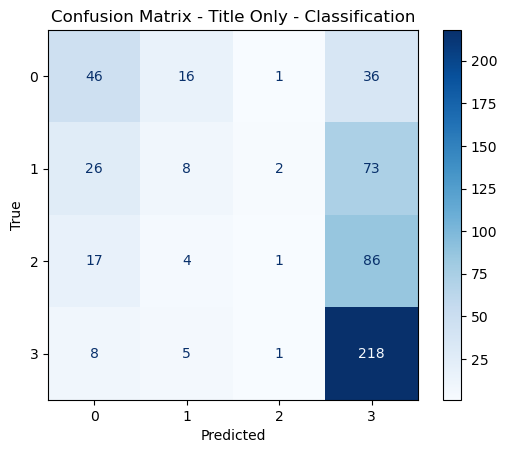


=== Running classification on: Text Only - Classification ===
Accuracy: 0.546
Precision: 0.469
Recall: 0.546
F1 Score: 0.468


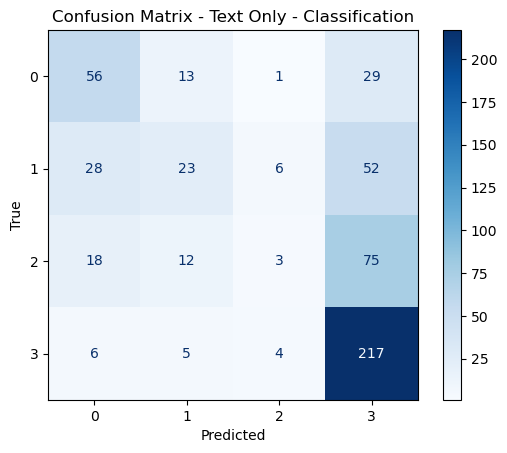


=== Running classification on: Title + Text - Classification ===
Accuracy: 0.526
Precision: 0.451
Recall: 0.526
F1 Score: 0.445


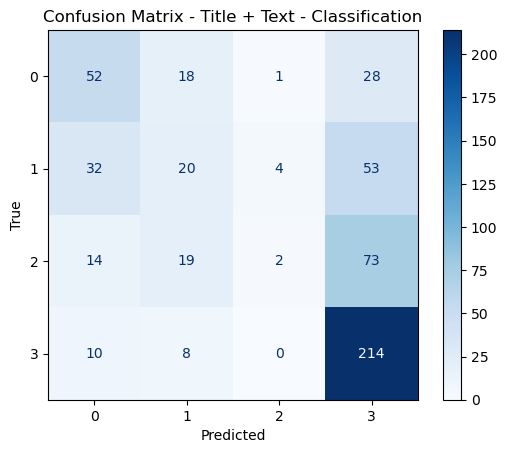


=== Running classification on: All Features - Classification ===
Accuracy: 0.666
Precision: 0.632
Recall: 0.666
F1 Score: 0.610


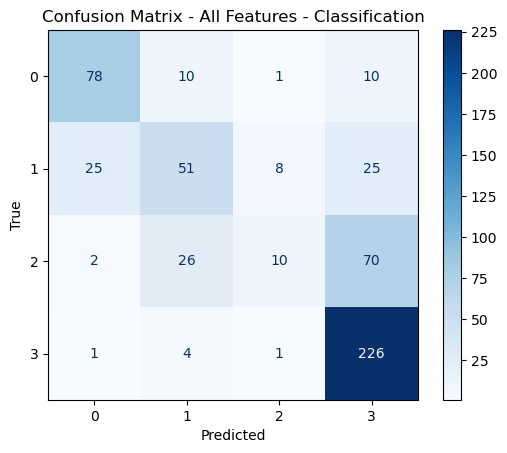

In [8]:
results = []

results.append(run_classification(df, extract_features_lang_aware(extract_title_features), None, "Title Only - Classification"))
results.append(run_classification(df, extract_features_lang_aware(extract_text_features), None, "Text Only - Classification"))
results.append(run_classification(df, extract_features_lang_aware(extract_combined_features), None, "Title + Text - Classification"))
results.append(run_classification(df, extract_features_lang_aware(extract_all_features), None, "All Features - Classification"))


## Regression with FastText

In [9]:
results.append(run_regression(df, extract_features_lang_aware(extract_title_features), None, "Title Only - Regression"))
results.append(run_regression(df, extract_features_lang_aware(extract_text_features), None, "Text Only - Regression"))
results.append(run_regression(df, extract_features_lang_aware(extract_combined_features), None, "Title + Text - Regression"))
results.append(run_regression(df, extract_features_lang_aware(extract_all_features), None, "All Features - Regression"))


=== Running classification on: Title Only - Regression ===
Mean Squared Error: 0.878
Mean Absolute Error: 0.787
R2 Score: 0.307

=== Running classification on: Text Only - Regression ===
Mean Squared Error: 0.731
Mean Absolute Error: 0.700
R2 Score: 0.423

=== Running classification on: Title + Text - Regression ===
Mean Squared Error: 0.739
Mean Absolute Error: 0.708
R2 Score: 0.416

=== Running classification on: All Features - Regression ===
Mean Squared Error: 0.122
Mean Absolute Error: 0.243
R2 Score: 0.904


## FastText Classification vs. Regression

In [10]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df.sort_values(by="Model"))


,Model,Accuracy,Precision,Recall,F1 Score,MSE,MAE,R2
3,All Features - Classification,0.666058,0.632011,0.666058,0.609600,NaN,NaN,NaN
7,All Features - Regression,NaN,NaN,NaN,NaN,0.122117,0.243069,0.903581
1,Text Only - Classification,0.545620,0.468519,0.545620,0.467616,NaN,NaN,NaN
5,Text Only - Regression,NaN,NaN,NaN,NaN,0.731100,0.699769,0.422749
2,Title + Text - Classification,0.525547,0.450685,0.525547,0.445340,NaN,NaN,NaN
6,Title + Text - Regression,NaN,NaN,NaN,NaN,0.739292,0.707533,0.416281
0,Title Only - Classification,0.498175,0.396775,0.498175,0.396875,NaN,NaN,NaN
4,Title Only - Regression,NaN,NaN,NaN,NaN,0.878309,0.786771,0.306519
